In [1]:
import os
import json
import gzip
import pickle
import numpy as np
import glob
import random 

import pandas as pd
from urllib.request import urlopen
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict
from tqdm import tqdm

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.metrics.pairwise import cosine_similarity

#nltk.download()
#nltk.download('stopwords')
#nltk.download('punkt')


#import more_itertools as mit
#from keras.preprocessing.sequence import pad_sequences


import torch
import torch.nn as nn
#from pytorch_pretrained_bert import BertTokenizer, BertModel
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset

In [2]:
bert_loaded = False

In [3]:
%%time

if not bert_loaded:
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_tokenizer.add_special_tokens({"unk_token": '[UNK]', 'cls_token': '[CLS]', 
                                       'pad_token':'[PAD]', 'sep_token':'[SEP]'})
    print(len(bert_tokenizer))
    assert bert_tokenizer.cls_token == '[CLS]'
    bert_tokenizer.sep_token_id
    
    bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True,
                                            output_attentions=True)
    bert_model.resize_token_embeddings(len(bert_tokenizer))
    
    bert_loaded = True

30522
CPU times: user 2.11 s, sys: 468 ms, total: 2.58 s
Wall time: 9.7 s


In [4]:
def parse(path, chunk_size=20000):
    i = 0
    with gzip.open(path, 'rb') as f:
        for l in f:
            yield json.loads(l.strip())
            i+=1
            if i == chunk_size:
                break
def parse2(f):
    for l in f:
        yield json.loads(l.strip())        
            
def getDF(path, chunk_size):
    i = 0
    df = {}
    for d in parse(path, chunk_size):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

def getDF_chunks(path, chunk_size, pkl_path, max_chunks=4):
    i = 0
    df = {}
    df_chunks = 0
    with gzip.open(path, 'rb') as f:
        for d in parse2(f):
            df[i] = d
            i+=1
            
            if i == chunk_size:
                df = pd.DataFrame.from_dict(df, orient='index')
                #preprocessing(df)
                df.to_pickle(pkl_path + "df" + str(df_chunks) +".pkl")
                df = {}
                i = 0
                df_chunks +=1
    return df_chunks, i

In [5]:
'''
!wget http://deepyeti.ucsd.edu/jianmo/amazon/sample/meta_Computers.json.gz
df = getDF('meta_Computers.json.gz')
len(df)
### remove rows with unformatted title (i.e. some 'title' may still contain html style content)

df3 = df.fillna('')
df4 = df3[df3.title.str.contains('getTime')] # unformatted rows
df5 = df3[~df3.title.str.contains('getTime')] # filter those unformatted rows
print("Unformatted rows: {} ({:.2f}%)".format(len(df4), len(df4)/len(df3)*100))
print("Remaining rows: {}".format(len(df5)))

'''

'\n!wget http://deepyeti.ucsd.edu/jianmo/amazon/sample/meta_Computers.json.gz\ndf = getDF(\'meta_Computers.json.gz\')\nlen(df)\n### remove rows with unformatted title (i.e. some \'title\' may still contain html style content)\n\ndf3 = df.fillna(\'\')\ndf4 = df3[df3.title.str.contains(\'getTime\')] # unformatted rows\ndf5 = df3[~df3.title.str.contains(\'getTime\')] # filter those unformatted rows\nprint("Unformatted rows: {} ({:.2f}%)".format(len(df4), len(df4)/len(df3)*100))\nprint("Remaining rows: {}".format(len(df5)))\n\n'

In [6]:
os.listdir('../datasets')

['meta_Computers.json.gz',
 'Electronics_5.json.gz',
 'out-pickle',
 'Books_5.json.gz',
 'one_week.tar.gz',
 'contentdata.tar.gz',
 'books-pickle']

In [7]:
def clean_text(sent, tokenizer, stop_words=None, stemmer=None):

    # tokenise & punctuation
    tokens = [word.lower() for word in tokenizer.tokenize(sent) if word.isalpha()]

    if not stop_words == None:
        #stop_words = list(set(stopwords.words('english')))
        # filter stop words
        tokens = [word for word in tokens if word not in stop_words]

    if not stemmer == None:
        tokens = [stemmer.stem(token) for token in tokens]

    # locating and correcting common typos & misspellings

    return tokens


def clean_df(df, drop_org_reviews=False):
    ### remove rows with unformatted title (i.e. some 'title' may still contain html style content)

    df = df.fillna('')
    df = df.drop(['reviewerName', 'style', 'vote', 'image'], axis=1)
    
    #reformat timestamp
    df['reviewTime'] = df['unixReviewTime'].apply(lambda x: pd.Timestamp(x, unit='s'))
    df = df.drop('unixReviewTime', axis=1)
    
    #rename columns
    df = df.rename(columns={'asin':'itemID'})
    
    #aggregate text
    df['reviewText'] = df['summary'] + " " + df['reviewText']
    df = df.drop('summary', axis=1)
    
    ## convert to other (smaller) datatype
    df['overall'] = df['overall'].astype('int32')
    
    #clean text
    if 'cleanedText' not in df.columns:
        print("Cleaning Text..")
        df['reviewWords'] = df['reviewText'].apply(lambda x: len(clean_text(x, bert_tokenizer)))
        if drop_org_reviews:
            df = df.drop('reviewText', axis=1)
        
    return df


def aggregate_info(df, user_d, items_d):
    
    added = 0
    updated = 0
    
    print("Aggregating User Stats..")
    for u, group in tqdm(df.groupby('reviewerID')):
        
        if u not in user_d:
            user_d[u] = {}
            user_d[u]['n_reviews'] = group['itemID'].count()
            user_d[u]['m_rating'] = group['overall'].mean()
            user_d[u]['m_words'] = group['reviewWords'].mean()
            added+=1
        else:
            user_d[u]['n_reviews'] += group['itemID'].count()
            user_d[u]['m_rating'] = np.mean([user_d[u]['m_rating'], group['overall'].mean()])
            user_d[u]['m_words'] = np.mean([user_d[u]['m_words'], group['reviewWords'].mean()])
            updated+=1

    print("Total users: %.0f" % len(user_d.keys()))
    print("Added: %.0f" % added)
    print("Updated: %.0f" % updated)
     
                
    #count reviews per item
    added = 0
    updated = 0
    
    print("Aggregating Item Stats..")
    for item, group in tqdm(df.groupby('itemID')):
    
        if item not in items_d:
            items_d[item] = {}
            items_d[item]['n_reviews'] = group['reviewerID'].count()
            items_d[item]['m_rating'] = group['overall'].mean()
            items_d[item]['m_words'] = group['reviewWords'].mean()
            added+=1
        else:
            items_d[item]['n_reviews'] += group['reviewerID'].count()
            items_d[item]['m_rating'] = np.mean([items_d[item]['m_rating'], group['overall'].mean()])
            items_d[item]['m_words'] = np.mean([items_d[item]['m_words'], group['reviewWords'].mean()])
            updated+=1
    
    print("Total items: %.0f" % len(items_d.keys()))
    print("Added: %.0f" % added)
    print("Updated: %.0f" % updated)  
    
    return user_d, items_d


def preprocessDF_chunks(path, chunk_size, pkl_path, drop_org_reviews=False, max_chunks=4):
    i = 0
    data = {}
    n_chunks = 0
    
    #aggreated info
    user_dict = {}
    item_dict = {}
    
    with gzip.open(path, 'rb') as f:
        print("Start reading: {}".format(path))
        for d in parse2(f):
            data[i] = d
            i+=1
            
            #if i == 10:
            #    print(d)
            
            if i == chunk_size:
                print("Processing Chunk {}".format(n_chunks))
                
                #print(list(data.items())[:2])
                
                df = pd.DataFrame.from_dict(data, orient='index')
                #preprocessing
                df = clean_df(df, drop_org_reviews)
                
                #aggregate info
                user_dict, item_dict = aggregate_info(df, user_dict, item_dict)
                
                #save cleaned dataframe
                df.to_pickle(pkl_path + "df" + str(n_chunks) +".pkl")
                
                #save stats
                with open(pkl_path + "user_stats.pkl", 'wb') as fout:
                    pickle.dump(user_dict, fout)
                with open(pkl_path + "item_stats.pkl", 'wb') as fout:
                    pickle.dump(item_dict, fout)
                
                i = 0
                data = {}
                n_chunks +=1
                print("\n")
                
            if max_chunks < n_chunks:
                break
                
    return n_chunks, i, user_dict, item_dict

In [8]:
(dirpath, dirnames, filenames) = next(os.walk('../datasets/books-pickle/'), (None, None, []))
filenames

['df.json',
 'item_stats.pkl',
 'pytorch_model.bin',
 'df.csv',
 'user_stats.pkl',
 'df.pkl',
 'config.json',
 'encoded_text.pkl']

In [9]:
#df=pd.read_pickle('../datasets/books-pickle/df.pkl')
#len(df)

10000

In [14]:
books_path = '../datasets/Books_5.json.gz'
chunk_size=10000
pkl_path = '../datasets/books-pickle/'

In [15]:
user_dict = {}
item_dict = {}

dev=True

if dev:
    df = getDF(books_path, chunk_size)
    df = clean_df(df)
    user_dict, item_dict = aggregate_info(df, user_dict, item_dict)
    
    # save cleaned dataframe & encoded text
    print("Saving ..")
    df.to_pickle(pkl_path + "df.pkl")

    # save stats
    with open(pkl_path + "user_stats.pkl", 'wb') as fout:
        pickle.dump(user_dict, fout)
    with open(pkl_path + "item_stats.pkl", 'wb') as fout:
        pickle.dump(item_dict, fout)
    
else:
    n_chunks, i, user_dict, item_dict = preprocessDF_chunks(books_path, chunk_size, pkl_path, drop_org_reviews=True, max_chunks=5)
    df = pickle.load(pkl_path + "df1.pkl")
    
print("###############")
print(len(df))

Cleaning Text..
Aggregating User Stats..


100%|██████████| 88/88 [00:00<00:00, 1291.99it/s]


Total users: 8908
Added: 8908
Updated: 0
Aggregating Item Stats..
Total items: 88
Added: 88
Updated: 0
Saving ..
###############
10000


In [16]:
len(user_dict.keys())

8908

In [13]:
import itertools
import json

import pandas as pd
from pandas.io.json._json import JsonReader


class JsonChunkReader(JsonReader):
    """JsonReader provides an interface for reading in a JSON file.
    """

    @classmethod
    def chunk_reader(cls, filepath_or_buffer, chunksize):
        return cls(
            filepath_or_buffer,
            orient=None,
            typ='frame',
            dtype=None,
            convert_axes=None,
            convert_dates=True,
            keep_default_dates=True,
            numpy=False,
            precise_float=False,
            date_unit=None,
            encoding=None,
            lines=True,
            chunksize=chunksize,
            compression=None,
        )

    def __next__(self):
        lines = list(itertools.islice(self.data, self.chunksize))
        if lines:
            obj = pd.DataFrame([
                json.loads(line)
                for line in lines
            ])
            return obj

        self.close()
        raise StopIteration


In [14]:
reader = pd.read_json("./Books_5.json",orient='index', chunksize=10000, lines=True)

In [15]:
#for chunk in reader:
#    print(1)

In [16]:
#df = pd.concat(reader, ignore_index=True)

In [15]:
#df = pd.read_json(pkl_path + "df.json", orient='index')

## User

In [17]:
print("Number of unique reviewers: {}".format(len(user_dict.keys())))

Number of unique reviewers: 8908


In [18]:
df[df["reviewerID"] == 'A1SDAYRVRR62ZH']['itemID'].count()

1

## Content

In [19]:
# tokenise content

In [20]:
row = 10 

sent = df['reviewText'].iloc[row]

print(len(sent))
print(sent)

477
Maybe It's Not As Bad As You Think So, you think you have problems? Things could be worse and this clever book can prove it. The king starts out with a problem. The mice are eating his cheese. The more he tries to fix the problem, the worse it gets. The king finally arranges to bring back the mice when he comes to the realization that his original dilemma  wasn't so intolerable after all. The solution requires cooperation from the king and the mice. It involves the cheese.


In [21]:
stop_words = list(set(stopwords.words('english')))
sent_tokenize(sent)

["Maybe It's Not As Bad As You Think So, you think you have problems?",
 'Things could be worse and this clever book can prove it.',
 'The king starts out with a problem.',
 'The mice are eating his cheese.',
 'The more he tries to fix the problem, the worse it gets.',
 "The king finally arranges to bring back the mice when he comes to the realization that his original dilemma  wasn't so intolerable after all.",
 'The solution requires cooperation from the king and the mice.',
 'It involves the cheese.']

In [23]:
tokens = [word for word in bert_tokenizer.tokenize(sent) if word.isalpha()]
print(len(tokens))

90


In [24]:
#tokenise, punctuation, lower-case
tokens = [word.lower() for sent in sent_tokenize(sent) for word in word_tokenize(sent) if word.isalpha()]

#filter stop words
#tokens = [word for word in tokens if word not in stop_words]

print(len(tokens))

88


In [25]:
review_length = df['reviewText'].apply(lambda x: len(x))
df[df['reviewText'].apply(lambda x: len(x)) < 10].count()

#plt.hist(review_length)

overall        5
verified       5
reviewTime     5
reviewerID     5
itemID         5
reviewText     5
reviewWords    5
dtype: int64

In [26]:
def clean_text_bert(text, tokenizer):
    return tokenizer.tokenize(text)

In [27]:
sent = "Let's see how text is handled if there're errors!!"
print(clean_text_bert(sent, bert_tokenizer))
print(bert_tokenizer.convert_tokens_to_ids(clean_text_bert(sent, bert_tokenizer)))

sent = "Let's see how txet is hanled if there're errors!!"
print(clean_text_bert(sent, bert_tokenizer))
print(bert_tokenizer.convert_tokens_to_ids(clean_text_bert(sent, bert_tokenizer)))

print(bert_tokenizer.encode(sent, max_length=30, add_special_tokens=True, pad_to_max_length=True))

['let', "'", 's', 'see', 'how', 'text', 'is', 'handled', 'if', 'there', "'", 're', 'errors', '!', '!']
[2292, 1005, 1055, 2156, 2129, 3793, 2003, 8971, 2065, 2045, 1005, 2128, 10697, 999, 999]
['let', "'", 's', 'see', 'how', 'tx', '##et', 'is', 'han', '##led', 'if', 'there', "'", 're', 'errors', '!', '!']
[2292, 1005, 1055, 2156, 2129, 19067, 3388, 2003, 7658, 3709, 2065, 2045, 1005, 2128, 10697, 999, 999]
[101, 2292, 1005, 1055, 2156, 2129, 19067, 3388, 2003, 7658, 3709, 2065, 2045, 1005, 2128, 10697, 999, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [28]:
row = 10 

sent = df['reviewText'].iloc[row]

print(len(sent))
print(sent)

477
Maybe It's Not As Bad As You Think So, you think you have problems? Things could be worse and this clever book can prove it. The king starts out with a problem. The mice are eating his cheese. The more he tries to fix the problem, the worse it gets. The king finally arranges to bring back the mice when he comes to the realization that his original dilemma  wasn't so intolerable after all. The solution requires cooperation from the king and the mice. It involves the cheese.


In [27]:
sent_tokenize(sent)

["Maybe It's Not As Bad As You Think So, you think you have problems?",
 'Things could be worse and this clever book can prove it.',
 'The king starts out with a problem.',
 'The mice are eating his cheese.',
 'The more he tries to fix the problem, the worse it gets.',
 "The king finally arranges to bring back the mice when he comes to the realization that his original dilemma  wasn't so intolerable after all.",
 'The solution requires cooperation from the king and the mice.',
 'It involves the cheese.']

In [33]:
bert_tokenizer.sep_token_id

102

In [35]:
bert_tokenizer.encode(sent)

[101,
 2672,
 2009,
 1005,
 1055,
 2025,
 2004,
 2919,
 2004,
 2017,
 2228,
 2061,
 1010,
 2017,
 2228,
 2017,
 2031,
 3471,
 1029,
 2477,
 2071,
 2022,
 4788,
 1998,
 2023,
 12266,
 2338,
 2064,
 6011,
 2009,
 1012,
 1996,
 2332,
 4627,
 2041,
 2007,
 1037,
 3291,
 1012,
 1996,
 12328,
 2024,
 5983,
 2010,
 8808,
 1012,
 1996,
 2062,
 2002,
 5363,
 2000,
 8081,
 1996,
 3291,
 1010,
 1996,
 4788,
 2009,
 4152,
 1012,
 1996,
 2332,
 2633,
 13621,
 2015,
 2000,
 3288,
 2067,
 1996,
 12328,
 2043,
 2002,
 3310,
 2000,
 1996,
 12393,
 2008,
 2010,
 2434,
 21883,
 2347,
 1005,
 1056,
 2061,
 2046,
 3917,
 3085,
 2044,
 2035,
 1012,
 1996,
 5576,
 5942,
 6792,
 2013,
 1996,
 2332,
 1998,
 1996,
 12328,
 1012,
 2009,
 7336,
 1996,
 8808,
 1012,
 102]

In [29]:
def truncate_seq(tokens, tokenizer, max_len=512):
    if len(tokens) < max_len:
        tokens=tokens[:-1]
        n = max_len - len(tokens) - 1
        tokens += n * [tokenizer.pad_token]
    elif len(tokens) > max_len:
        tokens=tokens[:max_len-1]
    else:
        return tokens
    
    tokens.append(tokenizer.sep_token)
    
    return tokens

def tokenize_text_to_ids(text, tokenizer, sent_tokenize, max_len=512):
    sents = sent_tokenize(text)
    tokens = []
    tokens.append(bert_tokenizer.cls_token)
    for s in sents:
        tokens.extend(bert_tokenizer.tokenize(s))
        tokens.append(bert_tokenizer.sep_token)
    
    tokens = truncate_seq(tokens, tokenizer, max_len)
    
    assert len(tokens) == max_len
    
    return bert_tokenizer.convert_tokens_to_ids(tokens)
#tokens[:-1]

In [27]:
tokens = bert_tokenizer.tokenize("This is a test.")
tokens.append(bert_tokenizer.sep_token)
truncate_seq(tokens, bert_tokenizer, max_len=10)

['this', 'is', 'a', 'test', '.', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[SEP]']

In [28]:
tokenize_text_to_ids("This is a test.", bert_tokenizer, sent_tokenize, max_len=10)

[101, 2023, 2003, 1037, 3231, 1012, 0, 0, 0, 102]

In [23]:
def truncate_seq(tokens, tokenizer, max_len=512):
    if len(tokens) < max_len:
        tokens=tokens[:-1]
        n = max_len - len(tokens) - 1
        tokens += n * [tokenizer.pad_token]
    elif len(tokens) > max_len:
        tokens=tokens[:max_len-1]
    else:
        return tokens
    
    tokens.append(tokenizer.sep_token)
    
    return tokens

def tokenize_text_to_ids(text, tokenizer, sent_tokenize, max_len=512):
    sents = sent_tokenize(text)
    tokens = []
    n_words = 0

    tokens.append(tokenizer.cls_token)
    added_tokens = 1

    for s in sents:
        # tokenise & punctuation
        #tokens.extend(tokenizer.tokenize(s))
        tokens.extend([word for word in tokenizer.tokenize(s) if word.isalpha()])
        tokens.append(tokenizer.sep_token)
        added_tokens += 1
    
    n_words = len(tokens) - added_tokens
    tokens = truncate_seq(tokens, tokenizer, max_len)
    
    assert len(tokens) == max_len
    
    return tokenizer.convert_tokens_to_ids(tokens), n_words

In [115]:
def prep_text(df, bert_tokenizer, bert_model, batch_size, max_len, device, drop_org_reviews=False):

    print("Encoding Text..")

    bert_model.to(device)

    encoded_text = {}
    start_idx = 0
    stop_idx = batch_size

    df["n_words"] = 0

    while(start_idx < len(df)):

        if stop_idx > len(df):
            stop_idx = len(df)

        encoded_in, n_words = zip(*[tokenize_text_to_ids(text, bert_tokenizer, sent_tokenize, max_len) for text
                  in list(df['reviewText'])[start_idx:stop_idx]])
        
        #encoded_in = out[:][0]
        #print(encoded_in)
        #print((start_idx, stop_idx))
        #print(len(n_words))       
        
        #assert batch_size == len(n_words)
        
        encoded_in = torch.tensor(encoded_in, requires_grad=False, device=device).long()

        #with torch.no_grad():
        #    last_hidden, pooled_out = bert_model(encoded_in)

        #assert last_hidden.shape[0] == batch_size

        #save tensor of encoded text into separate dictionary
        keys = range(start_idx, stop_idx)
        
        #encoded_text = {**encoded_text, **dict(zip(keys, last_hidden))}

        df.loc[keys, "n_words"] = n_words

        start_idx += (batch_size+1)
        stop_idx += (batch_size+1)

    print("done")
    if drop_org_reviews:
        df = df.drop('reviewText', axis=1)

    df.astype({"n_words":'int32'})
        
    return df, encoded_text

In [116]:
batch_size=2
max_len=100
device='cpu'

df, encoded_text = prep_text(df[:100], bert_tokenizer, bert_model, batch_size, 
                             max_len=max_len, drop_org_reviews=False, device=device)

Encoding Text..
done


## Analysis

In [26]:
print("Number of unique reviewers: {}".format(len(user_dict.keys())))
print("Number of unique items: {}".format(len(item_dict.keys())))

Number of unique reviewers: 8908
Number of unique items: 88


In [27]:
list(user_dict.keys())[0]

'A0334855HN6E38CXWXZR'

In [28]:
user_dict['A0334855HN6E38CXWXZR'].keys()

dict_keys(['n_reviews', 'm_rating', 'm_words'])

In [29]:
df_user = pd.DataFrame.from_dict(user_dict, orient='index')
print(len(df_user))
df_user.head()

8908


,n_reviews,m_rating,m_words
A0334855HN6E38CXWXZR,1,5.0,12.0
A0790722OCX87RKL2J3T,1,5.0,71.0
A100JBBLCC0NUC,1,5.0,27.0
A101OKMJFCIWYH,2,5.0,26.0
A1022R52JDJVMA,1,5.0,58.0


In [30]:
df_items = pd.DataFrame.from_dict(item_dict, orient='index')

Mean: 1.12
Median: 1.0
Std: 0.61


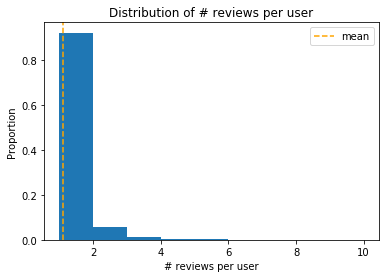

In [105]:
#reviews per user
plt.hist(df_user['n_reviews'], bins=[1,2,3,4,6,10], density=True)
plt.axvline(df_user['n_reviews'].mean(), color='orange', linestyle='--', label='mean')
print("Mean: %.2f" % df_user['n_reviews'].mean())
print("Median: %.1f" % df_user['n_reviews'].median())
print("Std: %.2f" % df_user['n_reviews'].std())
plt.xlabel('# reviews per user')
plt.ylabel('Proportion')
plt.title('Distribution of # reviews per user')

plt.legend()

In [43]:
min_reviews = 3
print("Users with more than {} reviews: {}".format(min_reviews, df_user[df_user['n_reviews'] > min_reviews]['n_reviews'].count()))
print("That's only {} %".format(df_user[df_user['n_reviews'] > min_reviews]['n_reviews'].count() / len(df_user)*100))

Users with more than 3 reviews: 94
That's only 1.055231252806466 %


In [ ]:
plt.hist(df_user['m_words'], bins=[10, 20, 50, 100, 150, 200, 300, 350], density=True)
plt.axvline(df_user['m_words'].mean(), color='orange', linestyle='--', label='mean')
plt.axvline(df_user['m_words'].median(), color='green', linestyle='--', label='median')


print("Mean: %.2f" % df_user['m_words'].mean())
print("Std: %.2f" % df_user['m_words'].std())
print("Median: %.1f" % df_user['m_words'].median())
print("Min: %.1f" % df_user['m_words'].min())

plt.xlabel('average # words per User')
plt.ylabel('Proportion')
plt.title('Distribution of # words per User')
plt.legend()

In [90]:
#m_words per user
def plot_words_per_user(df_user, bins=[10, 20, 50, 100, 150, 200, 300, 350]):
    plt.hist(df_user['m_words'], bins=bins, density=True)
    plt.axvline(df_user['m_words'].mean(), color='orange', linestyle='--', label='mean')
    plt.axvline(df_user['m_words'].median(), color='green', linestyle='--', label='median')


    print("Mean: %.2f" % df_user['m_words'].mean())
    print("Std: %.2f" % df_user['m_words'].std())
    print("Median: %.1f" % df_user['m_words'].median())
    print("Min: %.1f" % df_user['m_words'].min())
    print("Max: %.1f" % df_user['m_words'].max())

    plt.xlabel('average # words per User')
    plt.ylabel('Proportion')
    plt.title('Distribution of # words per User')
    plt.legend()

In [91]:
min_words = 90
print("Users with more than {} average words per review: {}".format(min_words, df_user[df_user['m_words'] > min_words]['n_reviews'].count()))
print("That's {}% of all users".format(df_user[df_user['m_words'] > min_words]['n_reviews'].count() / len(df_user)*100))

Users with more than 90 average words per review: 2395
That's 26.88594521778177% of all users


In [95]:
np.geomspace(min_words, int(user_subset['m_words'].max()), 8)

array([  90.        ,  141.29886531,  221.83743708,  348.28197936,
        546.79831656,  858.46646313, 1347.78152383, 2116.        ])

2395
Mean: 241.89
Std: 187.95
Median: 183.0
Min: 91.0
Max: 2116.0


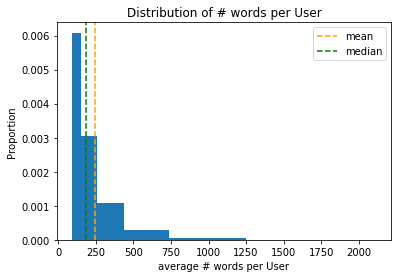

In [102]:
min_words = 90
user_subset = df_user[df_user['m_words'] > min_words]
print(len(user_subset))
plot_words_per_user(user_subset, bins=np.geomspace(min_words, int(user_subset['m_words'].max()), 7))

In [124]:
user_subset = df_user[df_user['n_reviews'] > min_reviews]

### Items

Mean: 113.64
Std: 328.94
Median: 26.5
Min: 1.0


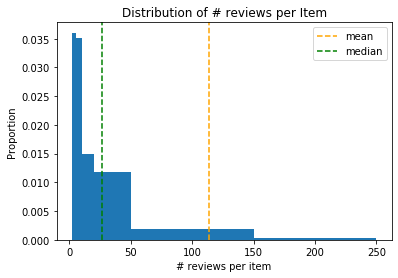

In [59]:
#reviews per item
plt.hist(df_items['n_reviews'], bins=[2,5,10, 20, 50, 150, 250], density=True)
plt.axvline(df_items['n_reviews'].mean(), color='orange', linestyle='--', label='mean')
plt.axvline(df_items['n_reviews'].median(), color='green', linestyle='--', label='median')
print("Mean: %.2f" % df_items['n_reviews'].mean())
print("Std: %.2f" % df_items['n_reviews'].std())
print("Median: %.1f" % df_items['n_reviews'].median())
print("Min: %.1f" % df_items['n_reviews'].min())

plt.xlabel('# reviews per item')
plt.ylabel('Proportion')
plt.title('Distribution of # reviews per Item')
plt.legend()

Mean: 103.33
Std: 69.10
Median: 82.0
Min: 21.7


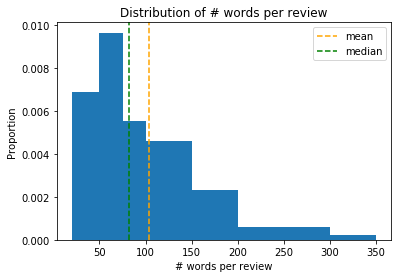

In [106]:
#m_words per item
plt.hist(df_items['m_words'], bins=[20, 50, 75, 100, 150, 200, 300, 350], density=True)
plt.axvline(df_items['m_words'].mean(), color='orange', linestyle='--', label='mean')
plt.axvline(df_items['m_words'].median(), color='green', linestyle='--', label='median')


print("Mean: %.2f" % df_items['m_words'].mean())
print("Std: %.2f" % df_items['m_words'].std())
print("Median: %.1f" % df_items['m_words'].median())
print("Min: %.1f" % df_items['m_words'].min())

plt.xlabel('# words per review')
plt.ylabel('Proportion')
plt.title('Distribution of # words per review')
plt.legend()

In [96]:
# TODO: plot distributions in with meaningful bin sizes/intervals, e.g. 1-2, 3-4, 5-7, >8

## Bert Stuff

In [36]:
#bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print(bert_tokenizer.convert_tokens_to_ids(bert_tokenizer.tokenize("Let's see all hidden-states and attentions on this text")))
#print(bert_tokenizer.convert_tokens_to_ids(bert_tokenizer.tokenize("Let's see all hidden-states? and attentions on this text")))

[2292, 1005, 1055, 2156, 2035, 5023, 1011, 2163, 1998, 3086, 2015, 2006, 2023, 3793]


In [37]:
word_embeddings = bert_model.get_input_embeddings()

In [38]:
sent = "This is a test-sentence, so let's see what happens"
#tokens = bert_tokenizer.tokenize(sent)
#tokens = ['[CLS]'] + list(tokens) + ['[SEP]']
#tokens = bert_tokenizer.convert_tokens_to_ids(tokens)

tokens = bert_tokenizer.encode(sent, max_length=30, add_special_tokens=True, pad_to_max_length=True)
x = torch.tensor(tokens, requires_grad=False).long()
tokens

[101,
 2023,
 2003,
 1037,
 3231,
 1011,
 6251,
 1010,
 2061,
 2292,
 1005,
 1055,
 2156,
 2054,
 6433,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [39]:
%%time
if not bert_loaded:
    bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True,
                                            output_attentions=True)
    
    bert_model.resize_token_embeddings(len(bert_tokenizer))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


In [40]:
x_in = torch.stack([x, x], dim=0)
x_in.shape

torch.Size([2, 30])

In [41]:
outputs = bert_model(x_in)
print(len(outputs))

4


In [42]:
#last hidden state
outputs[0].shape #batchsize x seq_length x hidden_units

torch.Size([2, 30, 768])

In [43]:
outputs[1].shape #pooled output

torch.Size([2, 768])

From the documentation: 
"This output is usually NOT a good summary of the semantic content of the input, 
you’re often better with averaging or pooling the sequence of hidden-states for the whole input sequence."

In [44]:
len(outputs[2]) #hidden_states at each output layer

13

In [45]:
outputs[2][-2].shape

torch.Size([2, 30, 768])

In [46]:
len(outputs[3]) #attentions

12

## Playground

In [49]:
x #tensor of shape seq_len containing word IDs

tensor([ 101, 2023, 2003, 1037, 3231, 1011, 6251, 1010, 2061, 2292, 1005, 1055,
        2156, 2054, 6433,  102,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0])

In [51]:
tokens_embedded = word_embeddings(x)
tokens_embedded.shape #seq_len x word_e

torch.Size([30, 768])

In [55]:
#word_embeddings(x_in)

In [56]:
last_hidden = outputs[0][0,:,:].squeeze()
last_hidden.shape

torch.Size([30, 768])

In [57]:
torch.equal(last_hidden, tokens_embedded)

False

In [58]:
last_hidden = last_hidden.view(1, last_hidden.shape[0], last_hidden.shape[1])
last_hidden.shape

torch.Size([1, 30, 768])

In [59]:
def output_size(l_in, pad, kernel, stride):
    l_out = l_in + 2*pad - kernel
    l_out /= stride
    l_out += 1
    return l_out

In [60]:
x = torch.sum(last_hidden, dim=1)
x.shape

torch.Size([1, 768])

In [61]:
x2 = torch.mean(last_hidden, dim=1)
x2.shape

torch.Size([1, 768])

In [62]:
text = {}

In [63]:

#text[0:10] = torch.zeros([10,10])
keys = range(0,11)
values = torch.zeros([len(keys), 10, 10])
text = {**text, **dict(zip(keys, values))}
text.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [64]:
keys = range(10,21)
values = torch.zeros([len(keys), 10, 10])
text = {**text, **dict(zip(keys, values))}

In [65]:
print(last_hidden.permute(0,2,1).size())

torch.Size([1, 768, 30])


In [66]:
avg_pool = torch.nn.AvgPool1d(2, stride=3)

avg_pool(last_hidden.permute(0,2,1)).shape

torch.Size([1, 768, 10])

In [67]:
torch.zeros(tokens_embedded.shape)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Options for Encoding Sentences: 
1. Bert Embeddings (Raw): tokenise text and apply Bert Embeddings, no further processing [batch_size x seq_len x dim_e] => subsequent (sophisticated) Encoder should produce sentence representation [batch_size x dim_s]
2. Last Hidden States: sequence encoded by Bert, powerful processing [batch_size x seq_len x dim_e] => subsequent (simple) Encoder produce sentence representation [batch_size x dim_s]
3. Average over Last Hidden States: seq. encoded by Bert and average in the end to yield sentence representation [batch_size x dim_s]

In [69]:
%%time
max_elems=2
encoded_in = [bert_tokenizer.encode(sent, max_length=30, add_special_tokens=True, pad_to_max_length=True) for sent in list(df['reviewText'])[:3]] 

CPU times: user 7.24 ms, sys: 148 µs, total: 7.39 ms
Wall time: 7.34 ms


In [70]:
len(encoded_in)

3

In [284]:
x_in = torch.tensor(encoded_in, requires_grad=False).long()

In [72]:
outputs = bert_model(x_in)[:2]

Options for Sentence Encoding

1. Use last hidden state of CLS 
2. Use average of last hidden states of all tokens 
3. Use average over multiple hidden layers (A) for CLS or (B) for all tokens

In [13]:
def clean_df(df):
    ### remove rows with unformatted title (i.e. some 'title' may still contain html style content)

    df = df.fillna('')
    df = df.drop(['reviewerName', 'style', 'vote'], axis=1)
    #df = df.drop('reviewerName', axis=1)
    #df = df.drop('style', axis=1)
    #df = df.drop('vote', axis=1)
    #df = df.drop('image', axis=1)

    # reformat timestamp
    df['reviewTime'] = df['unixReviewTime'].apply(lambda x: pd.Timestamp(x, unit='s'))
    df = df.drop('unixReviewTime', axis=1)

    # rename columns
    df = df.rename(columns={'asin': 'itemID'})

    # aggregate text
    df['reviewText'] = df['summary'] + " " + df['reviewText']
    df = df.drop('summary', axis=1)

    ## convert to other (smaller) datatype
    df['overall'] = df['overall'].astype('int32')

    return df


def prep_text(df, bert_tokenizer, bert_model, batch_size, max_len, device, drop_org_reviews=False):

    print("Cleaning Text..")
    #df['cleanedText'] = df['reviewText'].apply(lambda x: clean_text(x))
    df['reviewWords'] = df['reviewText'].apply(lambda x: len(clean_text(x, bert_tokenizer)))

    print("Encoding Text..")

    bert_model.to(device)

    encoded_text = {}
    start_idx = 0
    stop_idx = batch_size

    while(start_idx < len(df)):

        if stop_idx > len(df):
            stop_idx = len(df)

        encoded_in = [tokenize_text_to_ids(text, bert_tokenizer, sent_tokenize, max_len) for text
                  in list(df['reviewText'])[start_idx:stop_idx]]

        encoded_in = torch.tensor(encoded_in, requires_grad=False, device=device).long()

        with torch.no_grad():
            last_hidden, pooled_out = bert_model(encoded_in)

        assert last_hidden.shape[0] == batch_size

        #save tensor of encoded text into separate dictionary
        keys = range(start_idx, stop_idx+1)
        encoded_text = {**encoded_text, **dict(zip(keys, last_hidden))}

        start_idx += batch_size
        stop_idx += batch_size

    if drop_org_reviews:
        df = df.drop('reviewText', axis=1)

    return df, encoded_text

def preprocessDF_lisa(path, pkl_path, bert_tokenizer, bert_model, device, batch_size, max_len=200, drop_org_reviews=False):
    i = 0
    data = {}

    # aggreated info
    user_dict = {}
    item_dict = {}

    with gzip.open(path, 'rb') as f:
        print("Start reading: {}".format(path))
        for d in parse2(f):
            data[i] = d
            i += 1

            if not i % 100000:
                print(i)

    print("Lines read {}".format(i+1))
    print("Constructing DataFrame")
    df = pd.DataFrame.from_dict(data, orient='index')

    # preprocessing
    df = clean_df(df)

    # encode review text with Bert
    df, encoded_text = prep_text(df, bert_tokenizer, bert_model, batch_size, max_len=max_len, drop_org_reviews=True, device=device)

    # aggregate info
    user_dict, item_dict = aggregate_info(df, user_dict, item_dict)

    # save cleaned dataframe & encoded text
    print("Saving ..")
    df.to_pickle(pkl_path + "df.pkl")
    with open(pkl_path + "encoded_text.pkl", 'wb') as fout:
        pickle.dump(encoded_text, fout)

    # save stats
    with open(pkl_path + "user_stats.pkl", 'wb') as fout:
        pickle.dump(user_dict, fout)
    with open(pkl_path + "item_stats.pkl", 'wb') as fout:
        pickle.dump(item_dict, fout)

    print("\n")
    print("DONE")

    return user_dict, item_dict

### Creating Item Representation

1. Simple: Average pooling of all encoded reviews per Item

Considerations: 
- Variable number of reviews per item => avg + pooling
- Each review has same shape seq_emb
- Recurrency? 
- weighted importance of reviews -> attention
- try KimCNN

In [104]:
seq_emb = 64
item_ids = range(100)

In [105]:
torch.randn(seq_emb)

tensor([-0.7788, -0.1752, -1.4187, -1.2129, -1.5625, -0.6949, -0.0978,  1.9925,
        -0.8614, -0.2063, -0.6790, -0.0678,  0.5948, -0.6848,  2.0358,  1.2600,
         0.4632,  0.0183,  1.2962,  0.5226, -0.5426,  0.3172,  1.3800,  0.4215,
        -0.6946, -0.4134, -0.5079, -0.5923, -1.0295, -1.5446, -0.7742,  0.5573,
         0.0765, -1.3517, -1.4776, -0.7013, -1.9214,  0.4102, -0.3102,  0.6824,
        -1.0152,  0.6538, -0.0822,  0.7231, -2.4424, -0.2108, -1.9107,  0.0956,
        -0.0101, -0.6765, -1.4137,  0.8374, -0.2575,  0.1501,  0.0115,  1.6809,
         0.6018, -0.2314,  0.9818, -0.6832, -0.5440,  0.8054, -0.2465,  0.7479])

In [138]:
item_reviews = {}

for i in item_ids:
    item_reviews[i] = torch.stack([torch.randn(seq_emb)] * random.randint(5,10), dim=0)
    item_reviews[i] = torch.mean(item_reviews[i], dim=0)

In [139]:
item_reviews[0].shape

torch.Size([64])

In [174]:
user_reviews = {}
user_ids = range(20)

for i in user_ids:
    user_reviews[i] = {}
    for r in random.sample(list(item_reviews.keys()), random.randint(5,10)):
    #user_reviews[i] = dict(zip(random.sample(list(item_reviews.keys()), random.randint(5,10)), torch.randn(seq_emb)))
        user_reviews[i][r] = torch.randn(seq_emb)

In [209]:
user_reviews[0]
user_reviews.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [222]:
stacked_reviews_user = torch.stack([user_reviews[2][r] for r in user_reviews[2]])
stacked_reviews_user.shape

torch.Size([6, 64])

In [223]:
torch.stack([item_reviews[i] for i in user_reviews[2].keys()]).shape

torch.Size([6, 64])

In [258]:
def create_user_representations(user_reviews, item_reviews, method='avg_items'):
    user_repr = {}
    for u in user_reviews.keys():
        
        if 'avg_items' == method:
            stacked_reviews = torch.stack([item_reviews[i] for i in user_reviews[u].keys()])
            #print(stacked_user_reviews.shape)
            user_repr[u] = torch.mean(stacked_reviews, dim=0)
        elif 'avg_items_user' == method:
            stacked_reviews = torch.stack([item_reviews[i] for i in user_reviews[u].keys()])
            stacked_reviews_user = torch.stack([user_reviews[u][r] for r in user_reviews[u].keys()])
            user_repr[u] = torch.mean(stacked_reviews+stacked_reviews_user, dim=0)
    
    return user_repr

In [245]:
user_repr_avg = create_user_representations(user_reviews, item_reviews, method='avg_items')

In [246]:
user_repr_avg[0].shape

torch.Size([64])

In [256]:
user_repr_ui = create_user_representations(user_reviews, item_reviews, method='avg_items_user')
user_repr_ui[0] == user_repr_avg[0]

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False])

In [248]:
user_repr_avg[0].unsqueeze(0).shape

torch.Size([1, 64])

In [249]:
random.choice(list(user_reviews[0].keys()))

86

In [250]:
# test similarity between user and 1 item his items
cosine_similarity(user_repr_avg[0].unsqueeze(0), item_reviews[random.choice(list(user_reviews[0].keys()))].unsqueeze(0))

array([[0.32955277]], dtype=float32)

In [254]:
cos = []
for k in list(user_reviews[0].keys()):
    cos.append(cosine_similarity(user_repr_avg[0].unsqueeze(0), item_reviews[k].unsqueeze(0)).item())
    
print(np.mean(cos))
print(np.std(cos))

0.46191112995147704
0.07365378449664024


In [257]:
cos = []
for k in list(user_reviews[0].keys()):
    cos.append(cosine_similarity(user_repr_ui[0].unsqueeze(0), item_reviews[k].unsqueeze(0)).item())
    
print(np.mean(cos))
print(np.std(cos))

0.2634460687637329
0.0592251264411033


In [243]:
cosine_similarity(user_repr_ui[0].unsqueeze(0), user_repr_ui[0].unsqueeze(0)).item()

1.0

In [288]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, device, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.device = device
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device)
        return hidden

class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, device, drop_prob=0.2, bi=True):
        super(LSTMNet, self).__init__()
        self.device = device
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob, bidirectional=bi)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device))
        return hidden


In [269]:
#encode user with GRU

input_dim = seq_emb
hidden_dim = seq_emb
output_dim = seq_emb

stacked_reviews = torch.stack([item_reviews[i] for i in user_reviews[0].keys()])
n_layers = stacked_reviews.shape[0]
batch_size = 1
device = 'cpu'


model = GRUNet(input_dim, hidden_dim, output_dim, n_layers, device)
h = model.init_hidden(batch_size)
#if model_type == "GRU":
h = h.data
        
out, h = model(stacked_reviews.unsqueeze(0).float(), h)

In [274]:
h[-1].shape
#out.shape

torch.Size([1, 64])

In [281]:
user_repr_gru = h[-1].detach()

In [282]:
cos = []
for k in list(user_reviews[0].keys()):
    cos.append(cosine_similarity(user_repr_gru, item_reviews[k].unsqueeze(0)).item())

print(cos)
print(np.mean(cos))
print(np.std(cos))

[-0.0432269349694252, -0.07433795183897018, -0.08851823955774307, -0.1463300883769989, 0.10461973398923874]
-0.04955869615077972
0.08403289761568239


In [293]:
#tokenize_text_to_ids("This is a test.", bert_tokenizer, sent_tokenize, max_len=max_seq_len)

In [ ]:
out, h = model(stacked_reviews.unsqueeze(0).float(), h)